Reference:https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_PyTorch_Lightning.ipynb#scrollTo=yLCEbNfcbhk6

In [18]:
%pip install -q transformers datasets pytorch-lightning Pillow 
%pip install -q torch torchvision torchaudio tensorboard
%pip install -q numpy==1.26.4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load a portion of cifar-10 data

In [19]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes) 
train_ds, test_ds = load_dataset('cifar100', split=['train[:]', 'test[:]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 48863.48 examples/s]


In [20]:
train_ds

Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 45000
})

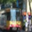

In [21]:

train_ds[0]['img']

In [23]:
id2label = {id:label for id, label in enumerate(train_ds.features['fine_label'].names)}
label2id = {label:id for id, label in id2label.items()}
label2id

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'cra': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,


In [24]:
id2label[train_ds[0]['fine_label']]

'streetcar'

In [25]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

In [27]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [28]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [29]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'fine_label': [81, 58],
 'coarse_label': [19, 18],
 'pixel_values': [tensor([[[-0.6314, -0.6314, -0.6314,  ...,  0.0431,  0.0431,  0.0431],
           [-0.6314, -0.6314, -0.6314,  ...,  0.0431,  0.0431,  0.0431],
           [-0.6314, -0.6314, -0.6314,  ...,  0.0431,  0.0431,  0.0431],
           ...,
           [-0.7412, -0.7412, -0.7412,  ...,  0.4353,  0.4353,  0.4353],
           [-0.7412, -0.7412, -0.7412,  ...,  0.4353,  0.4353,  0.4353],
           [-0.7412, -0.7412, -0.7412,  ...,  0.4353,  0.4353,  0.4353]],
  
          [[-0.5451, -0.5451, -0.5451,  ..., -0.0196, -0.0196, -0.0196],
           [-0.5451, -0.5451, -0.5451,  ..., -0.0196, -0.0196, -0.0196],
           [-0.5451, -0.5451, -0.5451,  ..., -0.0196, -0.0196, -0.0196],
           ...,
           [-0.7804, -0.7804, -0.7804,  ...,  0.3882,  0.3882,  0.3882],
           [-0.7804, -0.7804, -0

In [30]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["fine_label"] for example in examples])
    return {"pixel_values": pixel_values, "fine_labels": labels}

train_batch_size = 512
eval_batch_size = 512

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size)

In [31]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
fine_labels torch.Size([4])


In [33]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['fine_labels'].shape == (train_batch_size,)

In [34]:
next(iter(val_dataloader))['pixel_values'].shape

torch.Size([4, 3, 224, 224])

In [38]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=100):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=100,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['fine_labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

In [16]:
# Start tensorboard.
#%load_ext tensorboard
#%tensorboard --logdir ~/CIM/lightning_logs/

In [39]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule()
trainer = Trainer(callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                      | Params | Mode
----------------------------------------------------------
0 | vit  | ViTForImageClassification | 85.9 M | eval
----------------------------------------------------------
85.9 M    Trainable params
0         Non-trainable params
85.9 M    Total params
343.502   Total estimated model params size (MB)


Epoch 0:  46%|████▌     | 5168/11250 [03:32<04:10, 24.27it/s, v_num=7]     

In [ ]:
trainer.test()

Restoring states from the checkpoint path at /home/aesop/CIM/lightning_logs/version_4/checkpoints/epoch=5-step=13500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/aesop/CIM/lightning_logs/version_4/checkpoints/epoch=5-step=13500.ckpt


Testing DataLoader 0: 100%|██████████| 1000/1000 [00:06<00:00, 144.97it/s]


[{}]